#Extreme Value Analysis

Hello! Welcome to my notebook where we will explore the asymptotic distributions of the largest order statistic for the uniform, exponential , and pareto distributions. 

Specifically, we will explore whether these specific distributions converge to their theoretical limits, using the Fisher-Tippett-Gnedenko theorem.

-------------------------------------------------------------------------------------------------------------------------------------------------------------

**Theory**

Let M be the largest orderstatistic for a specific distribution. According to the Fisher-Tippett-Gnedenko theorem, under certain conditions , there exists a sequence of numbers a and b such that as n goes to infinity:

(M-b)/a is a Generalised Extreme Value distribution, with parameters mu(location), sigma(scale) and epsilon(shape).

Theoretical parameters of GEV after a and b have been applied

**Exponential**(*lambda): mu = 0, sigma = 1, shape = 0*

*a = 1/lambda*
*b = log(n)/lambda*


**Pareto**(*alpha,lambda*)*: mu = lambda, sigma = lambda/alpha, shape = 1/alpha*

*a = n^(1/alpha),
b = 0*

**Uniform**(*c,d): mu = -1, sigma = 1, shape = -1*

*a = (d - c)/n
b = d*


We can also have a GEV even if a and b have not been applied to M.

**Exponential**(*lambda): mu = log(n)/lambda, sigma = 1/lambda, shape = 0*

*a = 1/lambda*
*b = log(n)/lambda*


**Pareto**(*alpha,lambda*)*: mu = lambda*n^(1/alpha), sigma = lambda*n^(1/alpha)/alpha, shape = 1/alpha*

*a = n^(1/alpha),
b = 0*

**Uniform**(*c,d): mu = -b - (b-a)/n, sigma = (b-a)/n, shape = -1*

*a = (d - c)/n
b = d*

#Loading in packages, making data and setting parameters.

In [0]:
#install the required libraries
install.packages("EnvStats")
install.packages("evd")
install.packages("ismev")
install.packages("actuar")
install.packages("goftest")
install.packages("maxLik")



#Load in the libraries
library(EnvStats)
library(ismev)
library(actuar)
library(evd)
library(goftest)
library(maxLik)
options(warn = -1,echo = FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘nortest’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘expint’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘zoo’, ‘miscTools’, ‘sandwich’


Attaching package: ‘EnvStats’

The following objects are masked from ‘package:stats’:

    predict, predict.lm

The following object is masked from ‘package:base’:

    print.default

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Attaching package: ‘actuar’

The following object

We will do the analysis in the following manner:

1. Generate 1000 exponential, uniform , and pareto numbers. We will use a seed to keep track of our work.

2. We will then create to datasets based on the initial 1000 numbers for each distributions: 1 with the transformation performed and the other without the transformation.

3. Fit the datasets to the GEV and see the results.

4. Perform goodness of fitness tests.

4. Repeat the experiment 1000 times and see what results we get.

**Parameters**

We are going to use the following distributions to test the theory: Exponential(2.5), Uniform(1.5,3) and Pareto(2,3)

In [0]:
#Exponential (2.5)
lambda = 2.5

#Uniform (1.5,3)
a = 1.5
b = 3

#Pareto (2,3)
alpha = 2
beta = 3

#Functions to do the heavy lifting

These functions will help in fitting the GEV to the data.

In [0]:
#Simulate
simulate <- function(distribution,parameters,number) {
  
  #A place to store the final results
  storage = vector()
  
  #This is to direct the function whether to use the 2 parameter case or the 2 parameter case
  if (identical(distribution,runif) | identical(distribution,rpareto1)){
    
    #1 parameter case
    for (i in 1:number){
      #Select the larget observation from the 1000 simulations
      obs = sort(distribution(1000,parameters[1], parameters[2]), decreasing = TRUE)[1]
      
      #Store that value in a vector
      storage = append(storage,obs)
      
    }
    
  }else {
    
    #2 parameter case
    for (i in 1:number){
      #Select the largest observation from the 1000 simulations
      obs = sort(distribution(1000, parameters), decreasing = TRUE)[1]
      
      #Store that value in a vector
      storage = append(storage, obs)
    }
  }
  
  return(storage)
}

#Diagnostic
gof.test_1 <- function(data,name_of_dist,test,gev_obj){
  
  #Make a condition for 2 parameter and 3 parameter situations
  if(name_of_dist=="pgumbel"){
    
    result = test(data, name_of_dist,loc=gev_obj$mle[1],scale=gev_obj$mle[2])
    
  }else if(name_of_dist =="prweibull") {
    
    result = test(data,name_of_dist,loc=gev_obj$mle[1],scale=gev_obj$mle[2],shape=-gev_obj$mle[3])
    
  }else{
    
    result = test(data,name_of_dist,loc=gev_obj$mle[1],scale=gev_obj$mle[2],shape= gev_obj$mle[3])
  }
  
  return(result)
}

gof.test_2 <- function(data,name_of_dist,test,gev_obj){
 
    result = test(data,name_of_dist,loc=gev_obj$mu,scale=gev_obj$sigma,shape= gev_obj$E)
  
  
  return(result)
}


####For fitting the data
solve_expo <- function(x){
  
  #dataset
  data <- large_expo
  n <- length(large_expo)
  
  #varibles
  mu <- x[1]
  sigma <-  x[2]
  e <- x[3]
  
  
  #Log likelihood function
  log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))
  
 
  return(log_like)
}

solve_uniform <- function(x){
  
  #dataset
  data <- large_uniform
  n <- length(large_uniform)
  
  #varibles
  mu <- x[1]
  sigma <-  x[2]
  e <- x[3]
  
  
  #Log likelihood function
  log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))

  return(log_like)
}

solve_pareto <- function(x){
  
  #dataset
  data <- large_pareto
  n <- length(large_pareto)
  
  #varibles
  mu <- x[1]
  sigma <- x[2]
  e <- x[3]
  
  #Log likelihood function
  log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))
  
  
  return(log_like)
}



#Function to plot analytical mle fit
plot_mle <- function(dataset,mle_ting, title){

  #Sort the data
  data <- sort(dataset,decreasing =FALSE)
  #Make the histogram
  hist(data,freq = FALSE,100,ann =FALSE)
  #Plot the other plot over it
  par(new=TRUE)
  #Plot the red line over it
  density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
  if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
  plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red',main = title)

  
}



###Solve general###
mle_solve <- function(data,f){

  #Get the initial parameters
  initial_params <- c(mean(data) - 0.57722*sqrt(6*var(data))/pi,sqrt(6*var(data))/pi,0.1)
  
  #Fit the parameters
  mle_est <- maxLik(logLik=f, start = initial_params, method = "NM")$estimate
  a <- mle_est[1]
  b <- mle_est[2]
  c <- mle_est[3]
  
  #Return the parameters
  return(list(mu=a, sigma=b, E=c))
  
}

#Finding MLEs when the data is untransformed

**Making the observations**

In [0]:
#Define a seed (100)
set.seed(100)

#Number of simulations
obs = 1000

#Without transformation
#Exponential
large_expo = simulate(rexp,lambda,obs)
#Uniform
large_uniform = simulate(runif,c(a,b),obs)
#Pareto
large_pareto = simulate(rpareto1, c(alpha, beta),obs)

**Finding the MLE's for the GEV by maximising loglikelihood**


In [0]:
#Exponential
mle_expo <- mle_solve(large_expo,solve_expo)

#Uniform
mle_uniform <- mle_solve(large_uniform,solve_uniform)

#Pareto
mle_pareto <- mle_solve(large_pareto,solve_pareto)

#Show all of the parameters
matrix <- as.data.frame(rbind(mle_expo,mle_uniform, mle_pareto))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

                  mu       sigma          E
Exponential 2.769564   0.4029437 0.02139288
Uniform      2.99834 0.001851354  -1.118037
Pareto        93.928    47.10953  0.4974376


**Finding MLE using in-built R-functions for comparison**

In [0]:
#Exponential
fit_expo = gev.fit(large_expo)

#Uniform
fit_uniform = gev.fit(large_uniform)

#Pareto
fit_pareto = gev.fit(large_pareto)

#Show all of the parameters
matrix <- as.data.frame(rbind(fit_expo$mle,fit_uniform$mle, fit_pareto$mle))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

In [0]:
#Show all of the parameters
matrix <- as.data.frame(rbind(fit_expo$mle,fit_uniform$mle, fit_pareto$mle))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

                   mu        sigma           E
Exponential  2.769564  0.402943652  0.02139288
Uniform      2.998340  0.001851354 -1.11803715
Pareto      93.927999 47.109528590  0.49743756


**Diagnostic Plots for finding the MLE analytically**

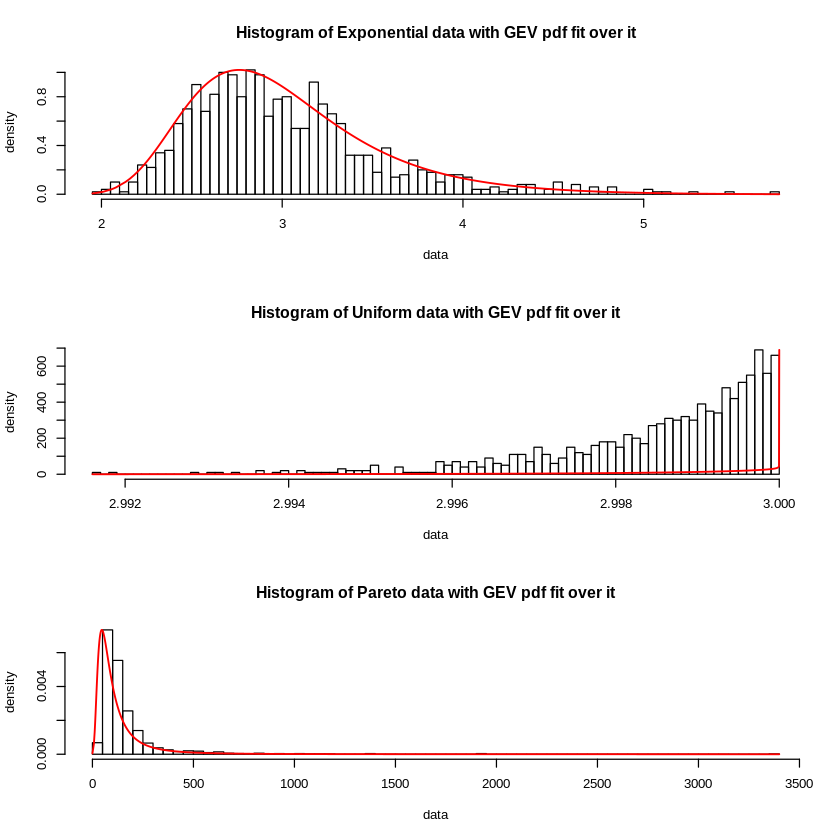

In [0]:
layout(matrix(c(1,2,3), nrow = 3, byrow = TRUE))

#Specify the dataset
dataset <- large_expo
#Specify the mle object
mle_ting <- mle_expo
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red',main = 'Histogram of Exponential data with GEV pdf fit over it')

#Make histogram with thign
#Specify the dataset
dataset <- large_uniform
#Specify the mle object
mle_ting <- mle_uniform
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red',main = 'Histogram of Uniform data with GEV pdf fit over it')

#Specify the dataset
dataset <- large_pareto
#Specify the mle object
mle_ting <- mle_pareto
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red', main = 'Histogram of Pareto data with GEV pdf fit over it')


**Goodness of fit tests after finding MLE's analytically**

*Exponential:GEV*

In [0]:
cat('Exponential to GEV')
###AD
gof.test_2(large_expo,"pgev",ad.test,mle_expo)
###CVM
gof.test_2(large_expo,"pgev",goftest::cvm.test,mle_expo)

Exponential to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.7695643678871, scale = 0.402943652303594,
	shape = 0.0213928826789993

data:  data
An = 0.31359, p-value = 0.9276



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.7695643678871, scale = 0.402943652303594,
	shape = 0.0213928826789993

data:  data
omega2 = 0.045533, p-value = 0.9029


*Uniform: GEV*

In [0]:
cat('Uniform to GEV')
###AD
gof.test_2(large_uniform,"pgev",ad.test,mle_uniform)
###CVM
gof.test_2(large_uniform,"pgev",goftest::cvm.test,mle_uniform)

Uniform to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.99834033646902, scale = 0.00185135387264238,
	shape = -1.11803714851565

data:  data
An = 9.4166, p-value = 1.866e-05



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.99834033646902, scale = 0.00185135387264238,
	shape = -1.11803714851565

data:  data
omega2 = 1.318, p-value = 0.0004478


*Pareto:GEV*

In [0]:
cat('Pareto to GEV')
###AD
gof.test_2(large_pareto,"pgev",ad.test,mle_pareto)
###CVM
gof.test_2(large_pareto,"pgev",goftest::cvm.test,mle_pareto)

Pareto to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 93.9279986440545, scale = 47.1095285901951,
	shape = 0.497437559680656

data:  data
An = 0.28306, p-value = 0.9503



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 93.9279986440545, scale = 47.1095285901951,
	shape = 0.497437559680656

data:  data
omega2 = 0.044635, p-value = 0.908


#Finding MLEs when the is transformed with an and bn

**Make the same observations as the first part**

In [0]:
#Define a seed (100)
set.seed(100)

#Number of simulations
obs = 1000

#With transformation
#Exponential
large_expo = (lambda*simulate(rexp,lambda,obs) - log(obs))
#Uniform
large_uniform = obs*(simulate(runif,c(a,b),obs)-b)/(b-a)
#Pareto
large_pareto = (simulate(rpareto1, c(alpha, beta),obs)/(obs^(1/alpha)))

**Finding MLEs by maximizing loglikelihood**

In [0]:
#Exponential
mle_expo <- mle_solve(large_expo,solve_expo)

#Uniform
mle_uniform <- mle_solve(large_uniform,solve_uniform)

#Pareto
mle_pareto <- mle_solve(large_pareto,solve_pareto)

#Show all of the parameters
matrix <- as.data.frame(rbind(mle_expo,mle_uniform, mle_pareto))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

                    mu     sigma          E
Exponential 0.01621403  1.007642 0.02137215
Uniform     -0.9561097 0.9370152 -0.9825915
Pareto        2.970714  1.490361  0.4974505


**Finding MLEs using in-built R functions for comparison**

In [0]:
#Exponential
fit_expo = gev.fit(large_expo)

#Uniform
fit_uniform = gev.fit(large_uniform)

#Pareto
fit_pareto = gev.fit(large_pareto)

#Show all of the parameters
matrix <- as.data.frame(rbind(fit_expo$mle,fit_uniform$mle, fit_pareto$mle))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

In [0]:
#Show all of the parameters
matrix <- as.data.frame(rbind(fit_expo$mle,fit_uniform$mle, fit_pareto$mle))
rownames(matrix) <- c('Exponential', 'Uniform','Pareto')
colnames(matrix) <- c("mu",'sigma','E')
print(matrix)

                     mu     sigma           E
Exponential  0.01621403 1.0076416  0.02137215
Uniform     -0.95610973 0.9370152 -0.98259151
Pareto       2.97071355 1.4903612  0.49745046


***Diagnostic Plots***

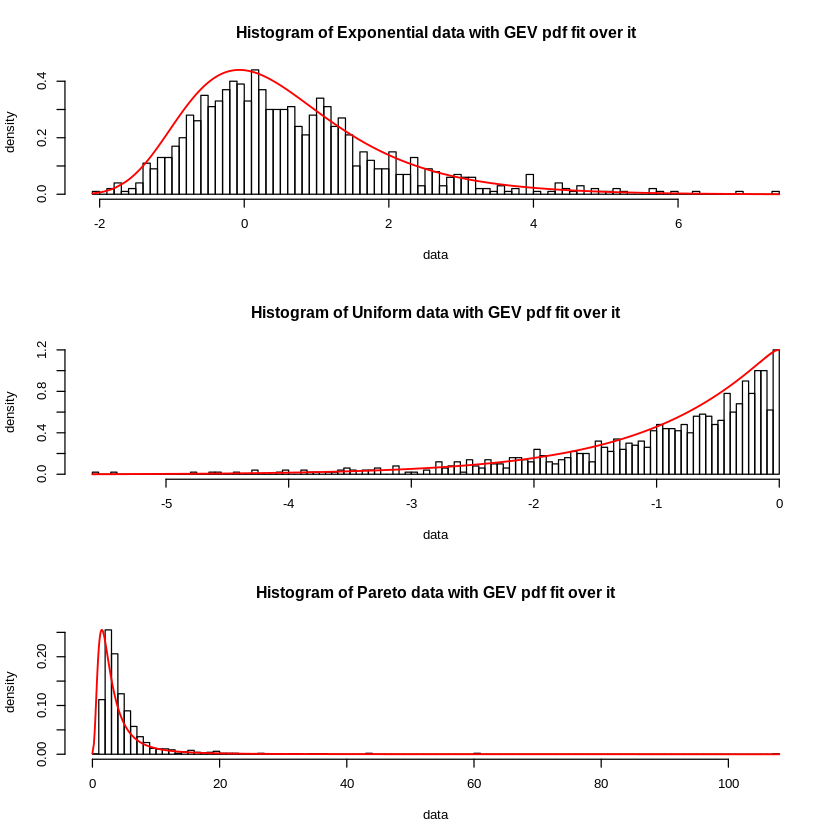

In [0]:
layout(matrix(c(1,2,3), nrow = 3, byrow = TRUE))

#Specify the dataset
dataset <- large_expo
#Specify the mle object
mle_ting <- mle_expo
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red',main = 'Histogram of Exponential data with GEV pdf fit over it')

#Make histogram with thign
#Specify the dataset
dataset <- large_uniform
#Specify the mle object
mle_ting <- mle_uniform
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red',main = 'Histogram of Uniform data with GEV pdf fit over it')

#Specify the dataset
dataset <- large_pareto
#Specify the mle object
mle_ting <- mle_pareto
#Sort the data
data <- sort(dataset,decreasing =FALSE)
#Make the histogram
hist(data,freq = FALSE,100,ann =FALSE)
#Plot the other plot over it
par(new=TRUE)

#Plot the red line over it
density <- dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E)
if(identical(dataset,eval(parse(text="large_uniform")))){density <- sort(dgev(data, loc = mle_ting$mu, scale = mle_ting$sigma, shape = mle_ting$E), decreasing = FALSE)}
plot(data,density, axes = FALSE, type = 'l', lwd= 1.5, col = 'red', main = 'Histogram of Pareto data with GEV pdf fit over it')


**Goodness of fit tests after finding MLE's analytically**

*Exponential:GEV*

In [0]:
cat('Exponential to GEV')
###AD
gof.test_2(large_expo,"pgev",ad.test,mle_expo)
###CVM
gof.test_2(large_expo,"pgev",goftest::cvm.test,mle_expo)

Exponential to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 0.0162140276183176, scale = 1.00764156252877,
	shape = 0.0213721524297245

data:  data
An = 0.31509, p-value = 0.9264



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 0.0162140276183176, scale = 1.00764156252877,
	shape = 0.0213721524297245

data:  data
omega2 = 0.045803, p-value = 0.9013


*Uniform:GEV*

In [0]:
cat('Uniform to GEV')
###AD
gof.test_2(large_uniform,"pgev",ad.test,mle_uniform)
###CVM
gof.test_2(large_uniform,"pgev",goftest::cvm.test,mle_uniform)

Uniform to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = -0.956109732808009, scale = 0.937015165290643,
	shape = -0.982591509888182

data:  data
An = 0.40027, p-value = 0.8484



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = -0.956109732808009, scale = 0.937015165290643,
	shape = -0.982591509888182

data:  data
omega2 = 0.046902, p-value = 0.8949


*Pareto:GEV*

In [0]:
cat('Pareto to GEV')
###AD
gof.test_2(large_pareto,"pgev",ad.test,mle_pareto)
###CVM
gof.test_2(large_pareto,"pgev",goftest::cvm.test,mle_pareto)

Pareto to GEV


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.97071355109826, scale = 1.49036122444937,
	shape = 0.497450458950668

data:  data
An = 0.28237, p-value = 0.9508



	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: distribution ‘pgev’
	with parameters loc = 2.97071355109826, scale = 1.49036122444937,
	shape = 0.497450458950668

data:  data
omega2 = 0.044368, p-value = 0.9095


# Doing an additional 1000 runs of the simulation

In [0]:
#Creating vectors and dataframes to store the output
store_exp_ad <- c(1:1000)
store_uni_ad <- c(1:1000)
store_par_ad <- c(1:1000)

store_exp_cvm  <- c(1:1000)
store_uni_cvm <- c(1:1000)
store_par_cvm  <- c(1:1000)

store_exp_ad_w <- c(1:1000)
store_uni_ad_w <- c(1:1000)
store_par_ad_w <- c(1:1000)

store_exp_cvm_w <- c(1:1000)
store_uni_cvm_w <- c(1:1000)
store_par_cvm_w <- c(1:1000)

expo_param_1 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)
uni_param_1 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)
par_param_1 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)


expo_param_2 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)
uni_param_2 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)
par_param_2 <- data.frame(Mu = 1:1000, Sigma = 1:1000, E = 1:1000)

obs = 1000

for (i in 1:1000){
  
  #Data Without transformation
  #Exponential
  data_expo_1 = simulate(rexp,lambda,obs)
  #Uniform
  data_uni_1 = simulate(runif,c(a,b),obs)
  #Pareto
  data_par_1 = simulate(rpareto1, c(alpha, beta),obs)
  
  
  #Data With transformation
  #Exponential
  data_expo_2 = (lambda*data_expo_1 - log(obs))
  #Uniform
  data_uni_2= obs*(data_uni_1-b)/(b-a)
  #Pareto
  data_par_2 = (data_par_1/(obs^(1/alpha)))
  
  ####For fitting the data
  solve_expo_1 <- function(x){

    #dataset
    data <- data_expo_1
    n <- length(large_expo)

    #varibles
    mu <- x[1]
    sigma <-  x[2]
    e <- x[3]


    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))


    return(log_like)
  }

  solve_uniform_1 <- function(x){

    #dataset
    data <- data_uni_1
    n <- length(large_uniform)

    #varibles
    mu <- x[1]
    sigma <-  x[2]
    e <- x[3]


    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))

    return(log_like)
  }

  solve_pareto_1 <- function(x){

    #dataset
    data <- data_par_1
    n <- length(large_pareto)

    #varibles
    mu <- x[1]
    sigma <- x[2]
    e <- x[3]

    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))


    return(log_like)
  }


  ####For fitting the data
  solve_expo_2 <- function(x){

    #dataset
    data <- data_expo_2
    n <- length(large_expo)

    #varibles
    mu <- x[1]
    sigma <-  x[2]
    e <- x[3]


    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))


    return(log_like)
  }

  solve_uniform_2 <- function(x){

    #dataset
    data <- data_uni_2
    n <- length(large_uniform)

    #varibles
    mu <- x[1]
    sigma <-  x[2]
    e <- x[3]


    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))

    return(log_like)
  }

  solve_pareto_2 <- function(x){

    #dataset
    data <- data_par_2
    n <- length(large_pareto)

    #varibles
    mu <- x[1]
    sigma <- x[2]
    e <- x[3]

    #Log likelihood function
    log_like <-  -(n*log(sigma)) - ((e+1)/e)*sum(log(1 + e*(data - mu)/sigma)) - sum((1 + e*(data - mu)/sigma)^(-1/e))


    return(log_like)
  }

  ###Solve general###
  mle_solve <- function(data,f){

    #Get the initial parameters
    initial_params <- c(mean(data) - 0.57722*sqrt(6*var(data))/pi,sqrt(6*var(data))/pi,0.1)

    #Fit the parameters
    mle_est <- maxLik(logLik=f, start = initial_params, method = "NM")$estimate
    a <- mle_est[1]
    b <- mle_est[2]
    c <- mle_est[3]

    #Return the parameters
    return(list(mu=a, sigma=b, E=c))

  }
  
  #with transformation
  #Exponential
  mle_expo_2 <- mle_solve(data_expo_2,solve_expo_2)
  #Uniform
  mle_uniform_2 <- try(mle_solve(data_uni_2,solve_uniform_2))
  #Pareto
  mle_pareto_2<- mle_solve(data_par_2,solve_pareto_2)
  
  #Without transformation
  mle_expo_1 <- mle_solve(data_expo_1,solve_expo_1)
  #Uniform
  mle_uniform_1 <- try(mle_solve(data_uni_1,solve_uniform_1))
  #Pareto
  mle_pareto_1 <- mle_solve(data_par_1,solve_pareto_1)
  
  
  expo_param_1[i,] <- mle_expo_1
  par_param_1[i,] <- mle_pareto_1


  expo_param_2[i,] <- mle_expo_2
  par_param_2[i,] <- mle_pareto_2
  
  if (is.null(mle_uniform_1$mu)){
    uni_param_1[i,] <- c(NA,NA,NA) 
  }else{
    uni_param_1[i,] <- try(mle_uniform_1)
  }
  
  if (is.null(mle_uniform_2$mu)){
    uni_param_2[i,] <- c(NA,NA,NA) 
  }else{
    uni_param_2[i,] <- try(mle_uniform_2)
  }
  
  
  #Without transformation
  ###AD
  store_exp_ad[i] <- gof.test_2(data_expo_1,"pgev",ad.test,mle_expo_1)$p.value
  store_uni_ad[i] <- try(gof.test_2(data_uni_1,"pgev",ad.test,mle_uniform_1)$p.value)
  store_par_ad[i] <- gof.test_2(data_par_1,"pgev",ad.test,mle_pareto_1)$p.value
  
  ###AD
  store_exp_cvm[i]  <- gof.test_2(data_expo_1,"pgev",goftest::cvm.test,mle_expo_1)$p.value
  store_uni_cvm[i] <- try(gof.test_2(data_uni_1,"pgev",goftest::cvm.test,mle_uniform_1)$p.value)
  store_par_cvm[i] <- gof.test_2(data_par_1,"pgev",goftest::cvm.test,mle_pareto_1)$p.value
  
  #With transformation
  ###AD
  store_exp_ad_w[i] <- gof.test_2(data_expo_2,"pgev",ad.test,mle_expo_2)$p.value
  store_uni_ad_w[i] <- try(gof.test_2(data_uni_2,"pgev",ad.test,mle_uniform_2)$p.value)
  store_par_ad_w[i] <- gof.test_2(data_par_2,"pgev",ad.test,mle_pareto_2)$p.value
  
  ###AD
  store_exp_cvm_w[i] <- gof.test_2(data_expo_2,"pgev",goftest::cvm.test,mle_expo_2)$p.value
  store_uni_cvm_w[i] <- try(gof.test_2(data_uni_2,"pgev",goftest::cvm.test,mle_uniform_2)$p.value)
  store_par_cvm_w[i] <- gof.test_2(data_par_2,"pgev",goftest::cvm.test,mle_pareto_2)$p.value
  
  print(i)
  
  
}

In [0]:
#Change data to numeric data
store_exp_ad <- as.numeric(store_exp_ad)
store_uni_ad <- as.numeric(store_uni_ad)
store_par_ad <- as.numeric(store_par_ad)

store_exp_cvm  <- as.numeric(store_exp_cvm)
store_uni_cvm <- as.numeric(store_uni_cvm)
store_par_cvm  <- as.numeric(store_par_cvm)

store_exp_ad_w <- as.numeric(store_exp_ad_w)
store_uni_ad_w <- as.numeric(store_uni_ad_w)
store_par_ad_w <- as.numeric(store_par_ad_w)

store_exp_cvm_w <- as.numeric(store_exp_cvm_w)
store_uni_cvm_w <- as.numeric(store_uni_cvm_w)
store_par_cvm_w <- as.numeric(store_par_cvm_w)

**GEV Parameters for Exponential distribution**

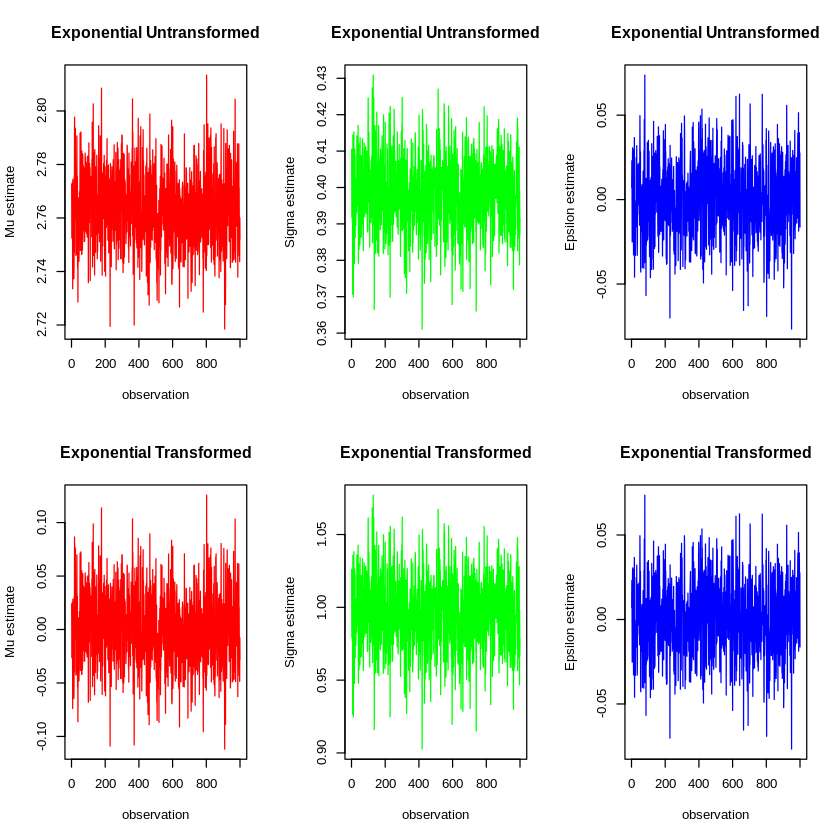

In [0]:
par(mfrow = c(2,3))
plot(x=1:1000, y =expo_param_1$Mu, type = 'l', col = 'red', ylab = 'Mu estimate', xlab = 'observation', main = 'Exponential Untransformed')
#par(new=TRUE)
plot(x=1:1000, y =expo_param_1$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Exponential Untransformed')
#par(new=TRUE)
plot(x=1:1000, y = expo_param_1$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Exponential Untransformed')

plot(x=1:1000, y =expo_param_2$Mu, type = 'l', col = 'red',ylab = 'Mu estimate', xlab = 'observation', main = 'Exponential Transformed' )
#par(new=TRUE)
plot(x=1:1000, y =expo_param_2$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Exponential Transformed')
#par(new=TRUE)
plot(x=1:1000, y = expo_param_2$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Exponential Transformed')

**GEV goodness-of-fit to Exponential data**

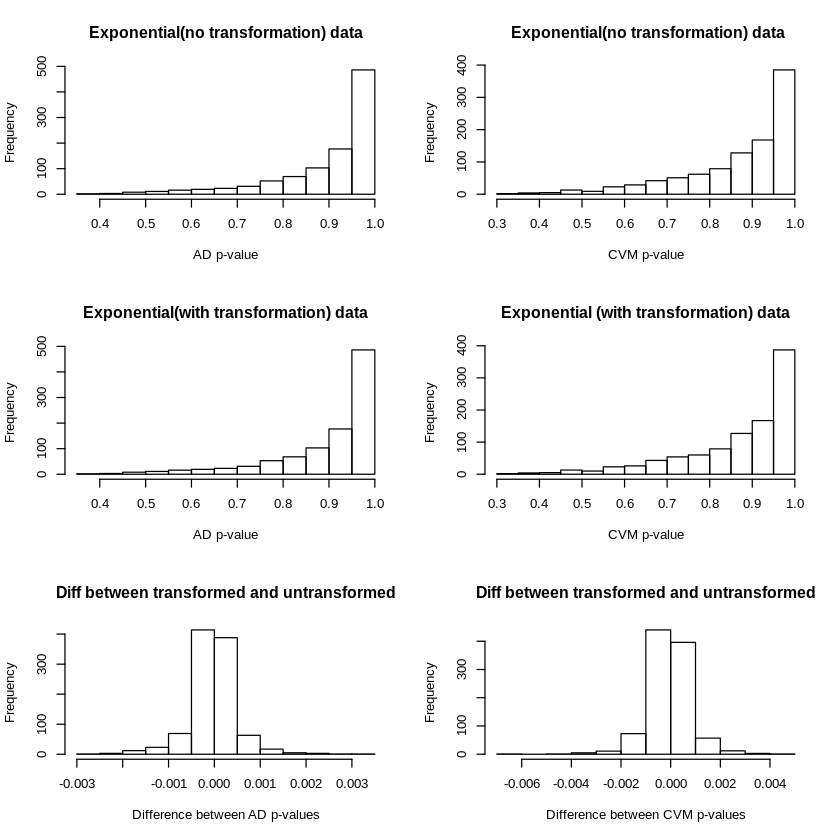

In [0]:
par(mfrow = c(3,2))
hist(store_exp_ad, main = "Exponential(no transformation) data", xlab = "AD p-value")
hist(store_exp_cvm, main = " Exponential(no transformation) data", xlab = "CVM p-value")
hist(store_exp_ad_w, main = "Exponential(with transformation) data", xlab = "AD p-value")
hist(store_exp_cvm_w, main = "Exponential (with transformation) data", xlab = "CVM p-value")
hist(store_exp_ad - store_exp_ad_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between AD p-values')
hist(store_exp_cvm - store_exp_cvm_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between CVM p-values')

**GEV Parameters for Uniform distribution**

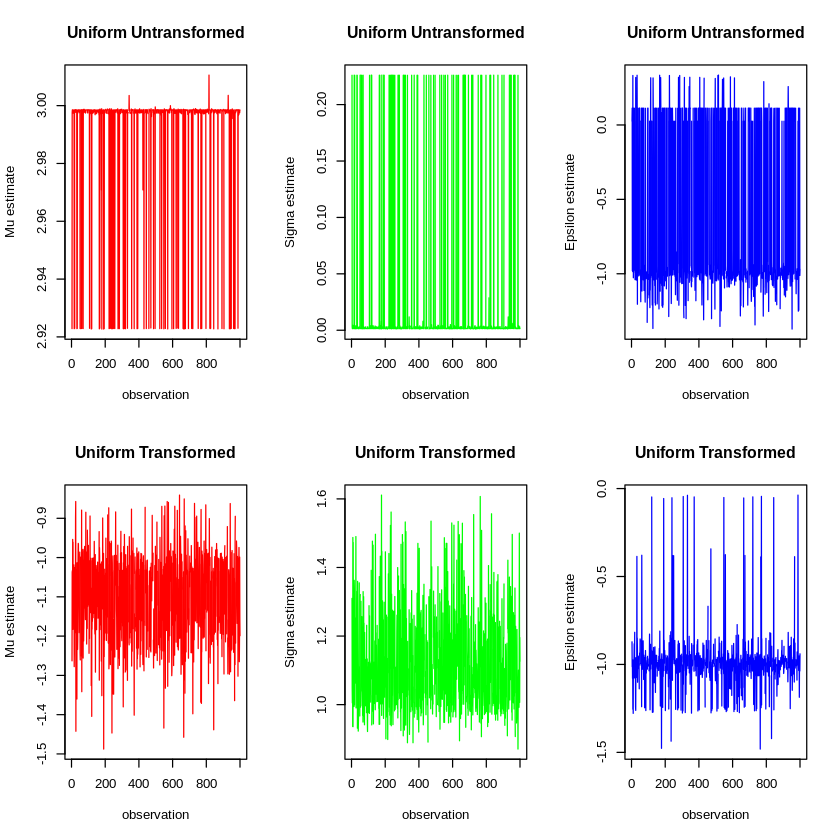

In [0]:
par(mfrow = c(2,3))
plot(x=1:1000, y =uni_param_1$Mu, type = 'l', col = 'red', ylab = 'Mu estimate', xlab = 'observation', main = 'Uniform Untransformed')
#par(new=TRUE)
plot(x=1:1000, y =uni_param_1$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Uniform Untransformed')
#par(new=TRUE)
plot(x=1:1000, y =uni_param_1$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Uniform Untransformed')

plot(x=1:1000, y =uni_param_2$Mu, type = 'l', col = 'red',ylab = 'Mu estimate', xlab = 'observation', main = 'Uniform Transformed' )
#par(new=TRUE)
plot(x=1:1000, y =uni_param_2$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Uniform Transformed')
#par(new=TRUE)
plot(x=1:1000, y =uni_param_2$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Uniform Transformed')

**GEV goodness-of-fit to Uniform data**

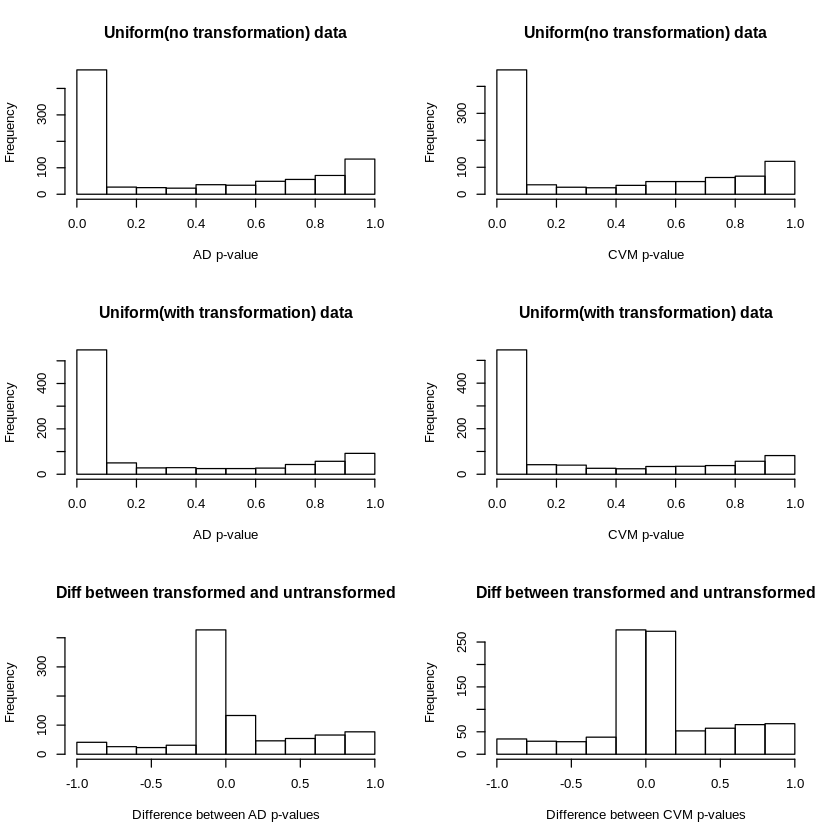

In [0]:
par(mfrow = c(3,2))
hist(store_uni_ad, main = "Uniform(no transformation) data", xlab = "AD p-value")
hist(store_uni_cvm, main = "Uniform(no transformation) data", xlab = "CVM p-value")
hist(store_uni_ad_w, main = "Uniform(with transformation) data", xlab = "AD p-value")
hist(store_uni_cvm_w, main = "Uniform(with transformation) data", xlab = "CVM p-value")
hist(store_uni_ad - store_uni_ad_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between AD p-values')
hist(store_uni_cvm - store_uni_cvm_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between CVM p-values')

**GEV parameters for Pareto distribution**

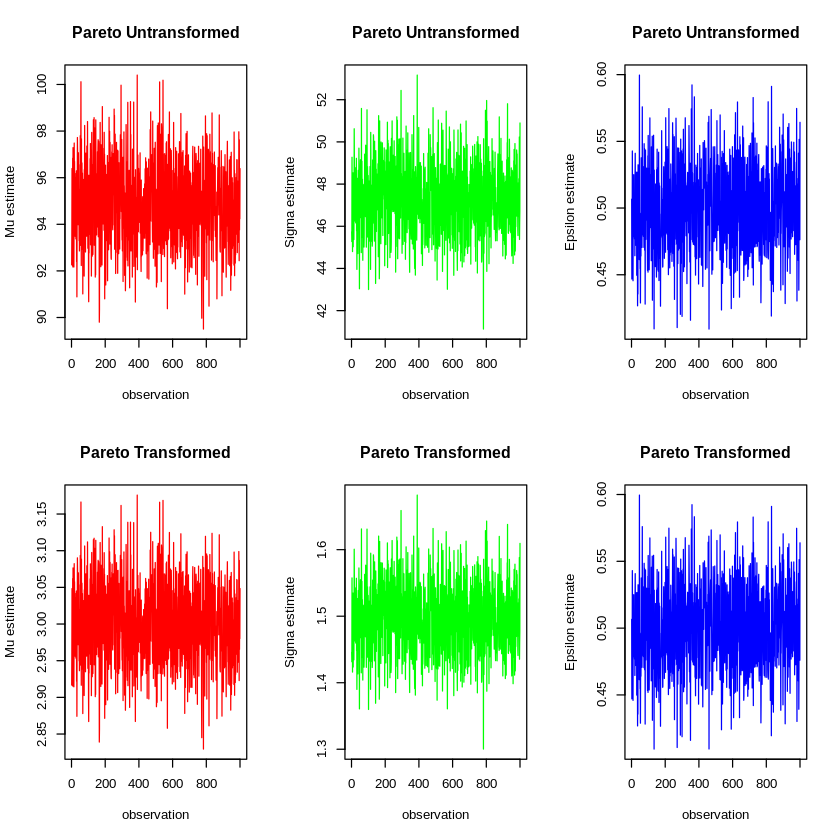

In [0]:
par(mfrow = c(2,3))
plot(x=1:1000, y =par_param_1$Mu, type = 'l', col = 'red', ylab = 'Mu estimate', xlab = 'observation', main = 'Pareto Untransformed')
#par(new=TRUE)
plot(x=1:1000, y =par_param_1$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Pareto Untransformed')
#par(new=TRUE)
plot(x=1:1000, y =par_param_1$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Pareto Untransformed')

plot(x=1:1000, y =par_param_2$Mu, type = 'l', col = 'red',ylab = 'Mu estimate', xlab = 'observation', main = 'Pareto Transformed' )
#par(new=TRUE)
plot(x=1:1000, y =par_param_2$Sigma, type = 'l',col = 'green',ylab = 'Sigma estimate', xlab = 'observation', main = 'Pareto Transformed')
#par(new=TRUE)
plot(x=1:1000, y =par_param_2$E, type = 'l', col = 'blue',ylab = 'Epsilon estimate', xlab = 'observation', main = 'Pareto Transformed')

**GEV goodness-of-fit to Pareto data**

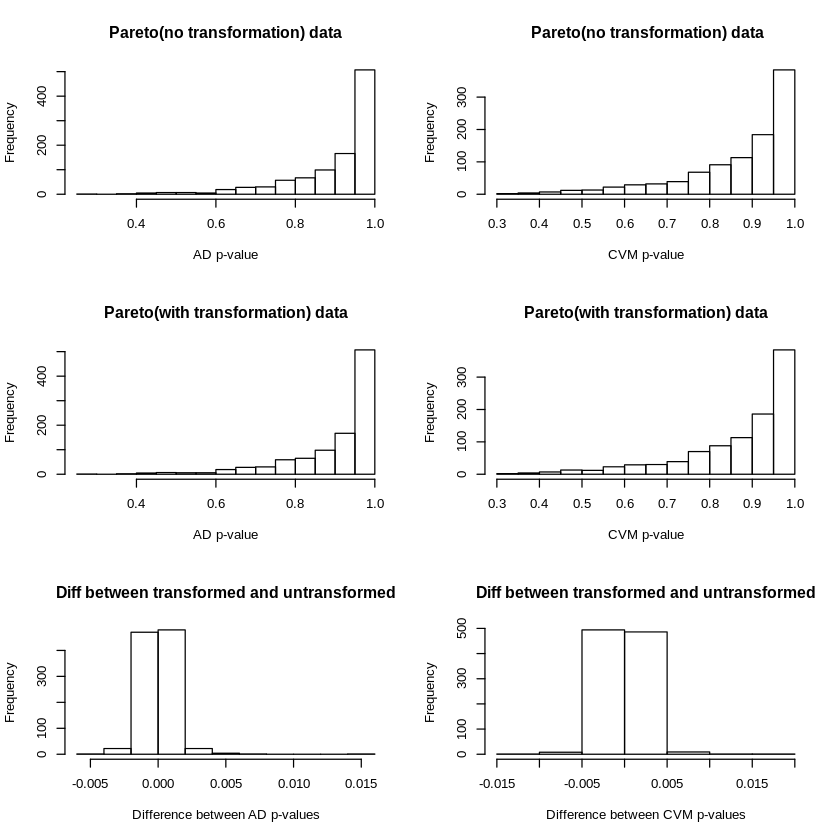

In [0]:
par(mfrow = c(3,2))

hist(store_par_ad, main = "Pareto(no transformation) data", xlab = "AD p-value")
hist(store_par_cvm, main = " Pareto(no transformation) data", xlab = "CVM p-value")
hist(store_par_ad_w, main = "Pareto(with transformation) data", xlab = "AD p-value")
hist(store_par_cvm_w, main = "Pareto(with transformation) data", xlab = "CVM p-value")
hist(store_par_ad - store_par_ad_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between AD p-values')
hist(store_par_cvm - store_par_cvm_w, main = 'Diff between transformed and untransformed', xlab = 'Difference between CVM p-values')

# Conclusions

> The GEV seems to generally fit well to the Pareto and Exponential data. This is shown by the low -p-values in the CVM and AD Tests.
> The GEV's fit to the uniform data seems bad and generally unstable. We can see this from the fluctuating p-values. This may be because of low sample size